In [1]:
%matplotlib inline

import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.model_selection import train_test_split


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
np.random.seed(0)

In [2]:
n_epocs = 1000
batch_size = 1
test_size = 0.2
learning_rate = 0.002 * (batch_size / 1024.0)
momentum = 0.0

In [3]:
class Connect4Dataset(data.Dataset):
    def __init__(self, boards, values):
        assert len(boards) == len(values)
        self.boards = boards
        self.values = values
        
    def __len__(self):
        return len(self.boards)
    
    def __getitem__(self, idx):
        return self.boards[idx], self.values[idx]

boards = torch.load('/home/richard/Downloads/connect4_boards.pth').numpy()
values = torch.load('/home/richard/Downloads/connect4_values.pth').numpy()

# Here we don't want to have the player to move channel
boards = boards[:, 1:]

board_train, board_test, value_train, value_test = train_test_split(boards, values, test_size=test_size, shuffle=True)

In [4]:
from src.connect4.utils import augment_data

# board_train, value_train = augment_data(board_train, value_train)

train = Connect4Dataset(torch.from_numpy(board_train), torch.from_numpy(value_train))
test = Connect4Dataset(torch.from_numpy(board_test), torch.from_numpy(value_test))

train_gen = data.DataLoader(train, batch_size, shuffle=True)
test_gen = data.DataLoader(test, batch_size, shuffle=True)

In [5]:
from src.connect4.neural import value_net as net

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.0000001)
    elif type(m) == nn.Conv2d:
        nn.init.normal_(m.weight, std=0.0000001)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, std=0.0000001)
#         nn.init.constant_(m.bias, 0)

# net.apply(init_normal)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ResidualLayer(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
      )
      (1): ResidualLayer(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [7]:
def categorise_predictions(preds):
    preds = preds * 3.0
    torch.floor_(preds)
    preds = preds / 2.0
    return preds

class Stats():
    def __init__(self):
        self.n = 0
        self.average_value = 0.0
        self.total_loss = 0.0
        self.smallest = 1.0
        self.largest = 0.0
        self.correct = {i : 0 for i in [0.0, 0.5, 1.0]}
        self.total = {i : 0 for i in [0.0, 0.5, 1.0]}
    
    @property
    def loss(self):
        return self.total_loss / self.n
    
    @property
    def accuracy(self):
        return float(sum(self.correct.values())) / self.n

    @property
    def average(self):
        return self.average_value / self.n
        

    def __repr__(self):
        x = "Average loss:  " + "{:.5f}".format(self.loss) + \
            ",  Accuracy:  " + "{:.5f}".format(self.accuracy) + \
            ",  Smallest:  " + "{:.5f}".format(self.smallest) + \
            ",  Largest:  " + "{:.5f}".format(self.largest) + \
            ",  Average:  " + "{:.5f}".format(self.average)
        
        for k in self.correct:
            x += "\nCategory, # Members, # Correct Predictions:  {}, {}, {}".format(
                k,
                self.total[k],
                self.correct[k])
        return x
    
    def update(self, outputs, values, loss):
        self.n += len(values)
        self.average_value += outputs.sum().item()
        self.total_loss += loss.item() * len(values)
        self.smallest = min(self.smallest, torch.min(outputs).item())
        self.largest = max(self.largest, torch.max(outputs).item())

        categories = categorise_predictions(outputs)
        values = values.view(-1)
        categories = categories.view(-1)

        for k in self.correct:
            idx = (values == k).nonzero()
            self.total[k] += len(idx)
            self.correct[k] += len(torch.eq(categories[idx], values[idx]).nonzero())

In [13]:
# criterion = nn.MSELoss()
# criterion2 = nn.MSELoss()
criterion = nn.L1Loss()
criterion2 = nn.L1Loss()

# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(net.parameters())

# # For classifier
# weight = torch.tensor([float(len(value_train) - len(value_train[value_train == i])) / len(value_train) for i in [1.0, 0.5, 0.0]])
# Actually isn't this the correct weight?
# weight = [1.0 / (3.0 * len(value_train[value_train == i]) / len(value_train)) for i in [1.0, 0.5, 0.0]]
# weight = weight.to(device)
# criterion = nn.CrossEntropyLoss(weight=weight)

In [8]:
# alternatively load it
# assert(False)
# checkpoint = torch.load('/home/richard/Downloads/nn.pth')
# net.load_state_dict(checkpoint['net_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [9]:
# Get an idea of how the initialisation is
test_stats = Stats()
with torch.set_grad_enabled(False):
    net = net.eval()
    for board, value in test_gen:
        board, value = board.to(device), value.to(device)

        output = net(board)
        loss = criterion2(output, value)

        test_stats.update(output, value, loss)

print("Initial Test Stats:\n", test_stats)

Initial Test Stats:
 Average loss:  0.24830,  Accuracy:  0.09458,  Smallest:  0.45195,  Largest:  0.45346,  Average:  0.45278
Category, # Members, # Correct Predictions:  0.0, 3300, 0
Category, # Members, # Correct Predictions:  0.5, 1278, 1278
Category, # Members, # Correct Predictions:  1.0, 8934, 0


Epoch:   0   Train:
 Average loss:  0.05398,  Accuracy:  0.35537,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.70856
Category, # Members, # Correct Predictions:  0.0, 13335, 12482
Category, # Members, # Correct Predictions:  0.5, 5171, 1543
Category, # Members, # Correct Predictions:  1.0, 35539, 5181 
Test:
 Average loss:  0.11165,  Accuracy:  0.26066,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.74342
Category, # Members, # Correct Predictions:  0.0, 3300, 2436
Category, # Members, # Correct Predictions:  0.5, 1278, 312
Category, # Members, # Correct Predictions:  1.0, 8934, 774


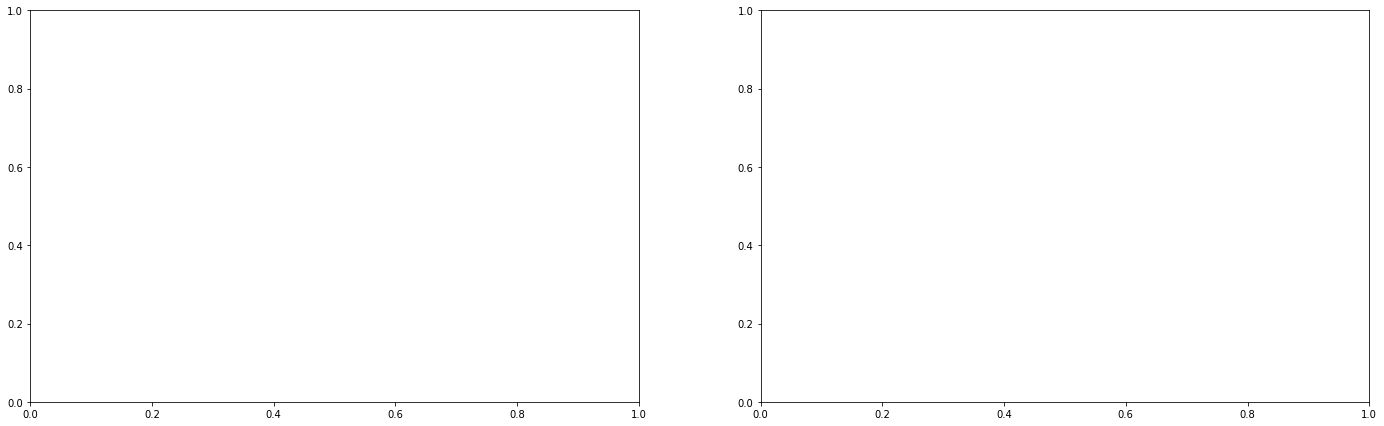

Epoch:   1   Train:
 Average loss:  0.06277,  Accuracy:  0.29337,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.71083
Category, # Members, # Correct Predictions:  0.0, 13335, 12202
Category, # Members, # Correct Predictions:  0.5, 5171, 1272
Category, # Members, # Correct Predictions:  1.0, 35539, 2381 
Test:
 Average loss:  0.10652,  Accuracy:  0.27516,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.72266
Category, # Members, # Correct Predictions:  0.0, 3300, 2647
Category, # Members, # Correct Predictions:  0.5, 1278, 273
Category, # Members, # Correct Predictions:  1.0, 8934, 798
Epoch:   2   Train:
 Average loss:  0.06924,  Accuracy:  0.28230,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.70898
Category, # Members, # Correct Predictions:  0.0, 13335, 12179
Category, # Members, # Correct Predictions:  0.5, 5171, 986
Category, # Members, # Correct Predictions:  1.0, 35539, 2092 
Test:
 Average loss:  0.10907,  Accuracy:  0.28256,  Smallest:  0.00000,  Largest:

Epoch:   15   Train:
 Average loss:  0.07413,  Accuracy:  0.27416,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.71354
Category, # Members, # Correct Predictions:  0.0, 13335, 11912
Category, # Members, # Correct Predictions:  0.5, 5171, 1023
Category, # Members, # Correct Predictions:  1.0, 35539, 1882 
Test:
 Average loss:  0.11227,  Accuracy:  0.22091,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.74717
Category, # Members, # Correct Predictions:  0.0, 3300, 2629
Category, # Members, # Correct Predictions:  0.5, 1278, 85
Category, # Members, # Correct Predictions:  1.0, 8934, 271
Epoch:   16   Train:
 Average loss:  0.07180,  Accuracy:  0.27564,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.71349
Category, # Members, # Correct Predictions:  0.0, 13335, 11899
Category, # Members, # Correct Predictions:  0.5, 5171, 1179
Category, # Members, # Correct Predictions:  1.0, 35539, 1819 
Test:
 Average loss:  0.11240,  Accuracy:  0.26147,  Smallest:  0.00000,  Larges

Epoch:   29   Train:
 Average loss:  0.07300,  Accuracy:  0.27386,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.71291
Category, # Members, # Correct Predictions:  0.0, 13335, 12110
Category, # Members, # Correct Predictions:  0.5, 5171, 837
Category, # Members, # Correct Predictions:  1.0, 35539, 1854 
Test:
 Average loss:  0.10150,  Accuracy:  0.25851,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.72533
Category, # Members, # Correct Predictions:  0.0, 3300, 2567
Category, # Members, # Correct Predictions:  0.5, 1278, 400
Category, # Members, # Correct Predictions:  1.0, 8934, 526
Epoch:   30   Train:
 Average loss:  0.06714,  Accuracy:  0.28225,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.71427
Category, # Members, # Correct Predictions:  0.0, 13335, 11909
Category, # Members, # Correct Predictions:  0.5, 5171, 1458
Category, # Members, # Correct Predictions:  1.0, 35539, 1887 
Test:
 Average loss:  0.10764,  Accuracy:  0.24734,  Smallest:  0.00000,  Larges

Epoch:   43   Train:
 Average loss:  0.06599,  Accuracy:  0.27122,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.71312
Category, # Members, # Correct Predictions:  0.0, 13335, 12039
Category, # Members, # Correct Predictions:  0.5, 5171, 1310
Category, # Members, # Correct Predictions:  1.0, 35539, 1309 
Test:
 Average loss:  0.10989,  Accuracy:  0.25392,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.69507
Category, # Members, # Correct Predictions:  0.0, 3300, 2743
Category, # Members, # Correct Predictions:  0.5, 1278, 335
Category, # Members, # Correct Predictions:  1.0, 8934, 353
Epoch:   44   Train:
 Average loss:  0.06604,  Accuracy:  0.27753,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.70795
Category, # Members, # Correct Predictions:  0.0, 13335, 12195
Category, # Members, # Correct Predictions:  0.5, 5171, 1324
Category, # Members, # Correct Predictions:  1.0, 35539, 1480 
Test:
 Average loss:  0.10764,  Accuracy:  0.22839,  Smallest:  0.00000,  Large

Epoch:   57   Train:
 Average loss:  0.09070,  Accuracy:  0.27943,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.68005
Category, # Members, # Correct Predictions:  0.0, 13335, 12249
Category, # Members, # Correct Predictions:  0.5, 5171, 1317
Category, # Members, # Correct Predictions:  1.0, 35539, 1536 
Test:
 Average loss:  0.10802,  Accuracy:  0.24956,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.74046
Category, # Members, # Correct Predictions:  0.0, 3300, 2449
Category, # Members, # Correct Predictions:  0.5, 1278, 345
Category, # Members, # Correct Predictions:  1.0, 8934, 578
Epoch:   58   Train:
 Average loss:  0.06029,  Accuracy:  0.29651,  Smallest:  0.00000,  Largest:  1.00000,  Average:  0.71352
Category, # Members, # Correct Predictions:  0.0, 13335, 12134
Category, # Members, # Correct Predictions:  0.5, 5171, 1538
Category, # Members, # Correct Predictions:  1.0, 35539, 2353 
Test:
 Average loss:  0.10663,  Accuracy:  0.29115,  Smallest:  0.00000,  Large

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [14]:
%%time

from laplotter import LossAccPlotter
from visdom import Visdom

viz = Visdom()
plotter = LossAccPlotter()

for epoch in range(n_epocs):
    
    net = net.train()
    train_stats = Stats()
    test_stats = Stats()
    
    for board, value in train_gen:
        board, value = board.to(device), value.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(board)
        loss = criterion(output, value)
        loss.backward()
        optimizer.step()
        
        train_stats.update(output, value, loss)

    # validate
    with torch.set_grad_enabled(False):
        net = net.eval()
        for board, value in test_gen:
            board, value = board.to(device), value.to(device)

            output = net(board)
            loss = criterion2(output, value)
            
            test_stats.update(output, value, loss)
            
    print("Epoch:  ", epoch, "  Train:\n", train_stats, "\nTest:\n", test_stats)
    plotter.add_values(epoch,
                       loss_train=train_stats.loss, acc_train=train_stats.average - train_stats.smallest,
                       loss_val=test_stats.loss, acc_val=test_stats.average - test_stats.smallest)
    if epoch == 0:
        win = viz.matplot(plotter.fig)
    else:
        viz.matplot(plotter.fig, win=win)
        
    torch.save({
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        '/home/richard/Downloads/nn/nn__now_linear' + str(epoch) + '.pth')
            

print('Finished Training')

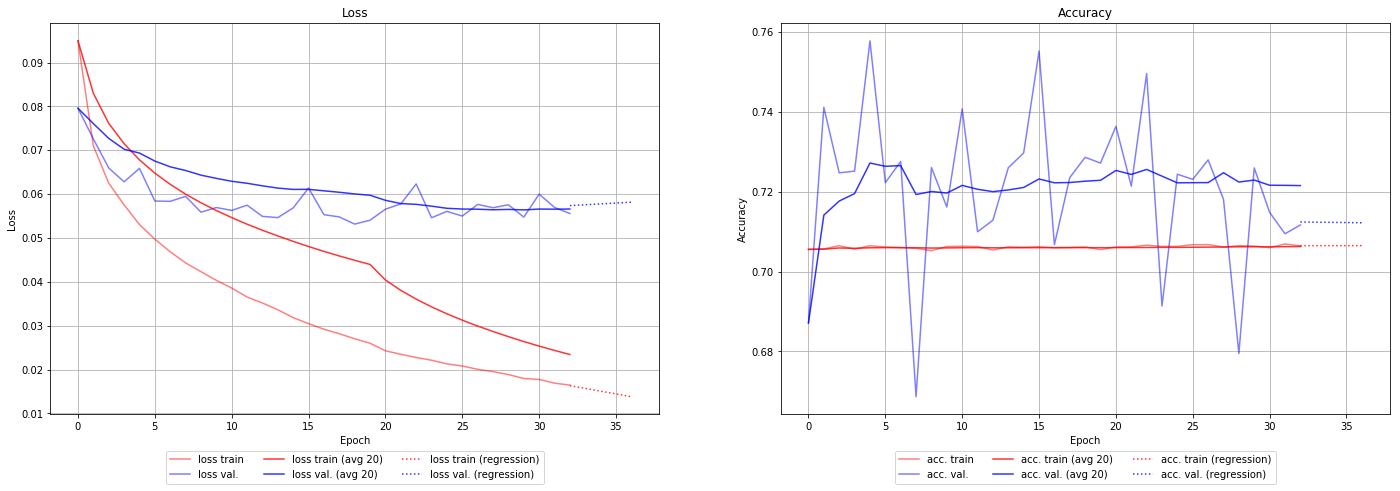

In [11]:
plotter.fig